# Airline Passenger Statisfaction
-------

Data from [Kaggle](https://www.kaggle.com/teejmahal20/airline-passenger-satisfaction)


In [172]:
import pandas as pd
import seaborn as sns

In [173]:
train_df = pd.read_csv("train.csv").drop(["id","Unnamed: 0"], axis=1) #gs://harmon_mlprojects/water_potability.csv")

Categorical Features
- Gender: Gender of the passengers (Female, Male)
- Customer Type: The customer type (Loyal customer, disloyal customer)
- Type of Travel: Purpose of the flight of the passengers (Personal Travel, Business Travel)
- Inflight wifi service: Satisfaction level of the inflight wifi service (0:Not Applicable;1-5)


Numerical (Continuous/Oridinal Features
- Age: The actual age of the passengers
- Inflight wifi service: Satisfaction level of the inflight wifi service (0:Not Applicable;1-5)
- Class: Travel class in the plane of the passengers (Business, Eco, Eco Plus)
- Flight distance: The flight distance of this journey
- Departure/Arrival time convenient: Satisfaction level of Departure/Arrival time convenient
- Ease of Online booking: Satisfaction level of online booking
- Gate location: Satisfaction level of Gate location
- Food and drink: Satisfaction level of Food and drink
- Online boarding: Satisfaction level of online boarding
- Seat comfort: Satisfaction level of Seat comfort
- Inflight entertainment: Satisfaction level of inflight entertainment
- On-board service: Satisfaction level of On-board service
- Leg room service: Satisfaction level of Leg room service
- Baggage handling: Satisfaction level of baggage handling
- Check-in service: Satisfaction level of Check-in service
- Inflight service: Satisfaction level of inflight service
- Cleanliness: Satisfaction level of Cleanliness
- Departure Delay in Minutes: Minutes delayed when departure
- Arrival Delay in Minutes: Minutes delayed when Arrival

Target: 
- Satisfaction: Airline satisfaction level(Satisfaction, neutral or dissatisfaction)

In [174]:
train_df.columns = [col.replace(" ", "_") for col in train_df.columns]

In [175]:
train_df["satisfaction"].unique()

array(['neutral or dissatisfied', 'satisfied'], dtype=object)

Will have to do something to deal with not applicable in Inflight Wifi:

In [176]:
train_df["Inflight_wifi_service"].value_counts()

3    25868
2    25830
4    19794
1    17840
5    11469
0     3103
Name: Inflight_wifi_service, dtype: int64

## Label Ordinal Variable for Class

In [177]:
class_encoder = OrdinalEncoder()#categories=["Eco", "Business", "Eco Plus"])
train_df["class"] = class_encoder.fit_transform(train_df[["Class"]])
train_df["class"] = train_df["class"].astype(int)

In [238]:
train_df[["Class","class"]]

,Class,class
0,Eco Plus,2
1,Business,0
2,Business,0
3,Business,0
4,Business,0
...,...,...
103899,Eco,1
103900,Business,0
103901,Business,0
103902,Eco,1


In [178]:
cat_feats = ["Gender","Customer_Type","Type_of_Travel"]

In [179]:
num_feats = ["Departure_Delay_in_Minutes",
             "Age",
             "Arrival_Delay_in_Minutes",
             "Flight_Distance"]

In [180]:
ord_feats = [col for col in train_df.columns if col not in ["Class", "satisfaction","target"] 
                                             and col not in cat_feats
                                             and col not in num_feats]

In [181]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

labeler = LabelEncoder().fit(train_df["satisfaction"])
train_df["target"] = labeler.transform(train_df["satisfaction"])

In [207]:
labeler.inverse_transform([1])

array(['satisfied'], dtype=object)

In [208]:
labeler.inverse_transform([0])

array(['neutral or dissatisfied'], dtype=object)

Count number of nulls

In [182]:
train_df.isnull().sum(axis = 0)

Gender                                 0
Customer_Type                          0
Age                                    0
Type_of_Travel                         0
Class                                  0
Flight_Distance                        0
Inflight_wifi_service                  0
Departure/Arrival_time_convenient      0
Ease_of_Online_booking                 0
Gate_location                          0
Food_and_drink                         0
Online_boarding                        0
Seat_comfort                           0
Inflight_entertainment                 0
On-board_service                       0
Leg_room_service                       0
Baggage_handling                       0
Checkin_service                        0
Inflight_service                       0
Cleanliness                            0
Departure_Delay_in_Minutes             0
Arrival_Delay_in_Minutes             310
satisfaction                           0
class                                  0
target          

Class sizes

<AxesSubplot:title={'center':'Class Counts'}>

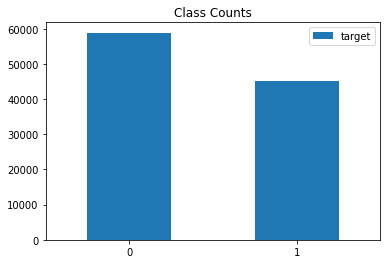

In [183]:
train_df["target"].value_counts().plot(kind="bar", title="Class Counts", legend=True,rot=0) 

Create long form of dataset to see distribution

In [184]:
train_df[num_feats].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 4 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Departure_Delay_in_Minutes  103904 non-null  int64  
 1   Age                         103904 non-null  int64  
 2   Arrival_Delay_in_Minutes    103594 non-null  float64
 3   Flight_Distance             103904 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.2 MB


In [185]:
long_num_df = train_df[num_feats + ["target"]].melt(id_vars="target")

In [186]:
long_ord_df = train_df[ord_feats + ["target"]].melt(id_vars="target")

In [187]:
long_cat_df = train_df[cat_feats + ["target"]].melt(id_vars="target")

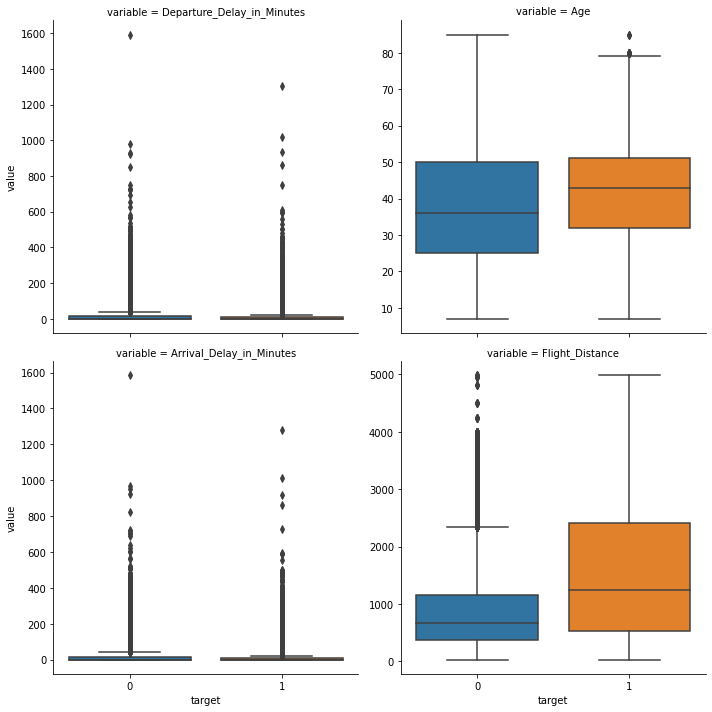

In [202]:
sns.catplot(
    data=long_num_df, x='target', y='value',
    col='variable', kind='box', col_wrap=2, 
    sharey=False
)

Some features have skew... meaning we should probably look to use median for imputing missing values over mean.

Look at scatter plot relationships

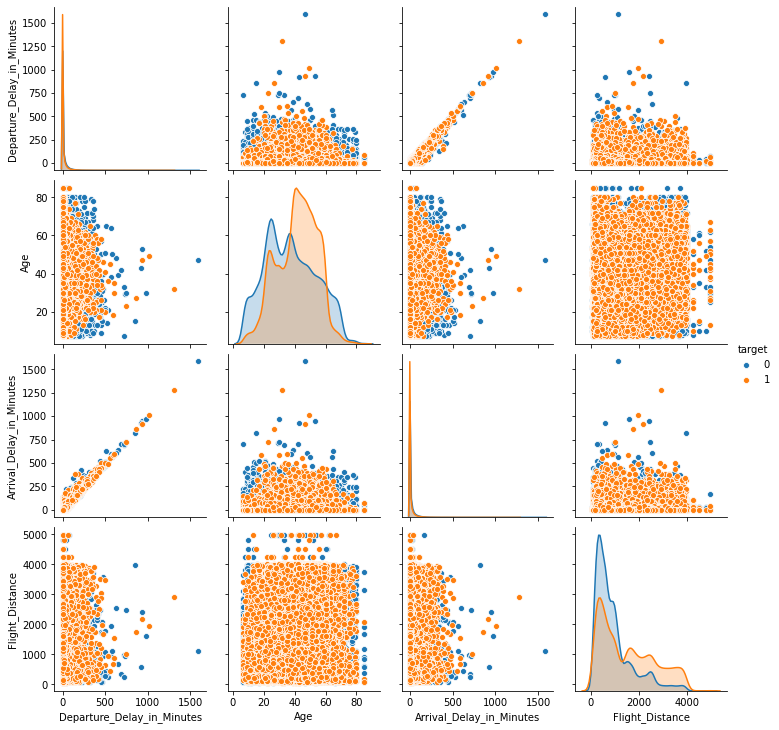

In [204]:
sns.pairplot(train_df[num_feats+["target"]],
             hue='target')

Pretty strong linear relationship with delay times.. can probably use linear regresssion to impute missing values or drop the one with missing values...

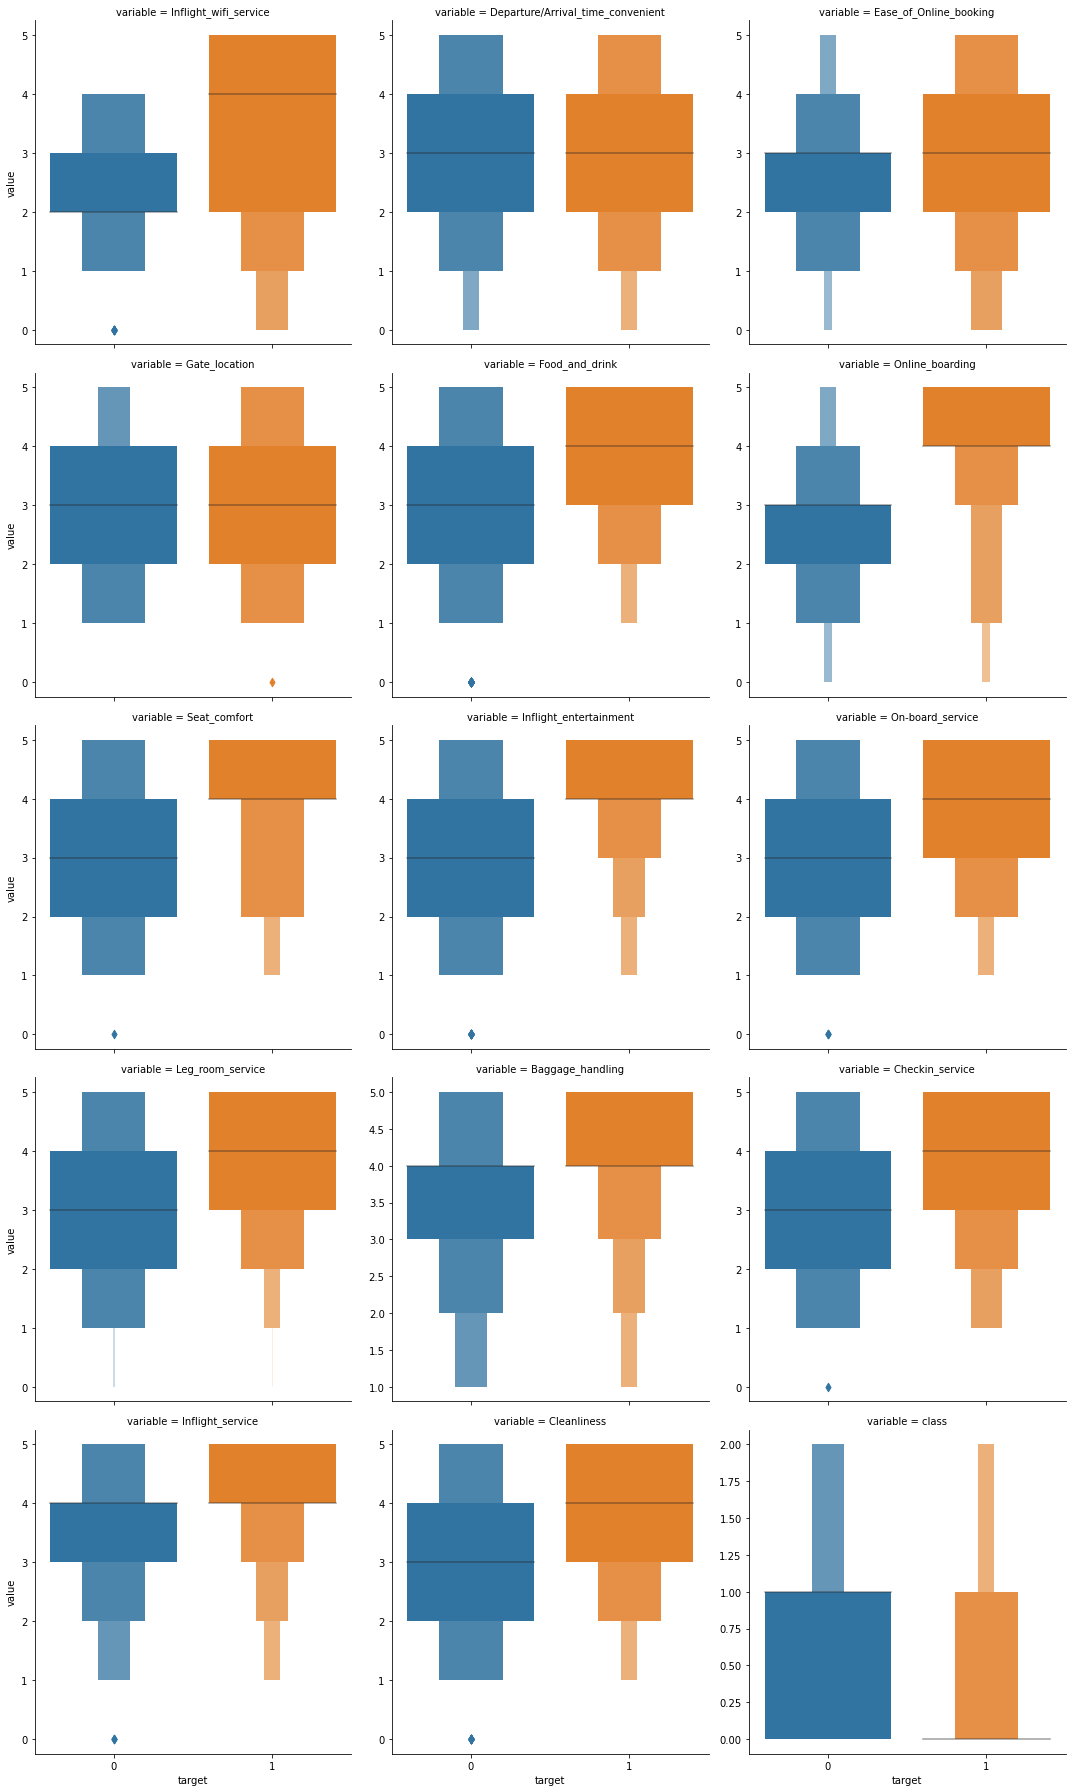

In [190]:
sns.catplot(
    data=long_ord_df, x='target', y='value',
    col='variable', kind='boxen', col_wrap=3, 
    sharey=False
)

No clear relationship between features so will need flexible model.. will start out with KNN

/Users/mukeharmon/miniconda3/envs/greenbuildings/lib/python3.7/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the catplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


TypeError: object of type 'NoneType' has no len()

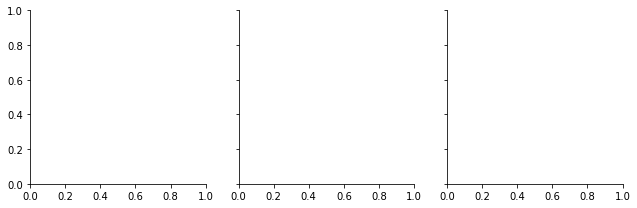

In [232]:
g = sns.FacetGrid(long_cat_df, hue="target", col="variable")
g.map(sns.catplot,"value",kind="count")

In [230]:
long_cat_df

,target,variable,value
0,0,Gender,Male
1,0,Gender,Male
2,1,Gender,Female
3,0,Gender,Female
4,1,Gender,Male
...,...,...,...
311707,0,Type_of_Travel,Business travel
311708,1,Type_of_Travel,Business travel
311709,0,Type_of_Travel,Business travel
311710,0,Type_of_Travel,Business travel


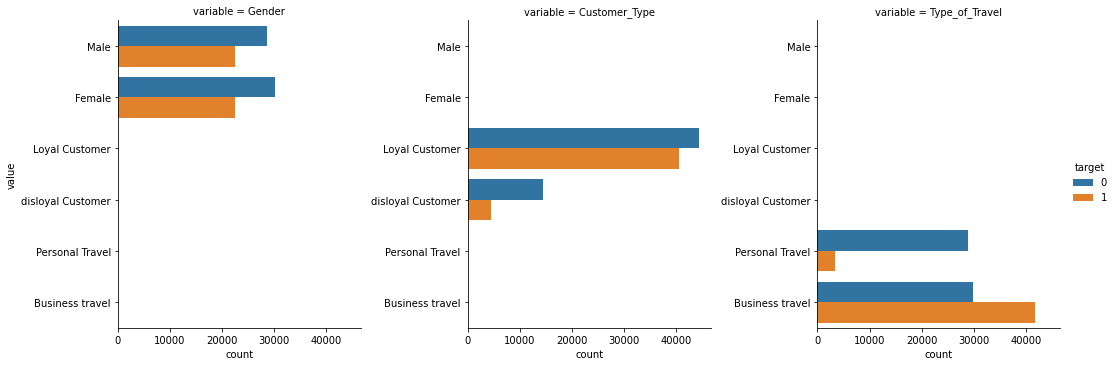

In [237]:
sns.catplot(
    data=long_cat_df, y='value', hue="target",
    col='variable', kind='count', col_wrap=3, 
    sharey=False
)

# sns.catplot(y="deck", hue="class", kind="count",
#             palette="pastel", edgecolor=".6",
#             data=titanic)